In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import PIL
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

In [17]:
# Initialization

# Dataset location
DATASET_PATH = "Datasets/electronic-components-png"

# resolution of images
TARGET_WIDTH = 28
TARGET_HEIGHT = 28

# invert image
INVERT = False

#Grayscale
GRAYSCALE = True

# 20%-validation, 20%-test
VAL_RATIO = 0.2
TEST_RATIO = 0.2
TRAIN_RATIO = 1 - VAL_RATIO - TEST_RATIO 

#Normalization mean
MEAN = (0.0864, 0.3011, 0.6495)
STD  =  (1.212, 1.425, 1.505)

GRAY_MEAN = (0.5)
GRAY_STD = (0.5)

# Hyperparameters
LR = 0.001
EPOCHS = 10
BATCH_SIZE = 10

In [18]:

class CustomDataset(Dataset):
    def __init__(self, path, mean, std, gray_mean, gray_std, train=True, invert=False, grayscale = True):
        self.path = path
        self.train = train
        self.invert = invert
        self.grayscale = grayscale
        
        self.transform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.ToTensor(),
            transforms.Normalize(gray_mean, gray_std) if self.grayscale 
            else transforms.Normalize(mean, std)
        ])
        
        # Initialize data storage
        self.data = []
        
        # Build class map dynamically from folder names
        self.class_map = {}
        
        if self.train:
            # Walk through the dataset directory to collect images and labels
            for root, dirs, files in os.walk(self.path):
                # Skip the root directory itself (only process subdirectories)
                if root == self.path:
                    continue
                
                # Get label from directory name
                label = os.path.basename(root)
                
                # Add label to class_map if not already present
                if label not in self.class_map:
                    self.class_map[label] = len(self.class_map)
                
                # Process each image file
                for file in files:
                    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(root, file)
                        self.data.append((label, img_path))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        class_name, img_path = self.data[index]
        
        # Load and transform image
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        if self.grayscale and image.shape[0] == 3:  # RGB
            image = transforms.functional.rgb_to_grayscale(image)
        if self.invert:
            image = 255 - image
        # Get class ID from mapping
        class_id = self.class_map[class_name]
        
        return image, torch.tensor(class_id)

In [19]:
# Load dataset
dataset = CustomDataset(DATASET_PATH, MEAN, STD, GRAY_MEAN, GRAY_STD, grayscale = GRAYSCALE)

# Print unique labels and their counts
unique_labels = set()
for label, _ in dataset.data:
    unique_labels.add(label)

print(f"Found {len(unique_labels)} unique classes:")
for i, label in enumerate(sorted(unique_labels)):
    print(f"{i}: {label} (Count: {sum(1 for l, _ in dataset.data if l == label)})")

Found 5 unique classes:
0: background (Count: 50)
1: capacitor (Count: 50)
2: diode (Count: 50)
3: led (Count: 50)
4: resistor (Count: 50)


In [ ]:
# dividing into train, test and validation set
num_dataset = len(dataset.data)
num_test = int(TEST_RATIO * num_dataset)
num_val = int(VAL_RATIO * num_dataset)
num_train = int(TRAIN_RATIO * num_dataset)

In [21]:
from torch.utils.data import random_split

train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [num_train, num_val, num_test],
    generator=torch.Generator().manual_seed(42)  
)

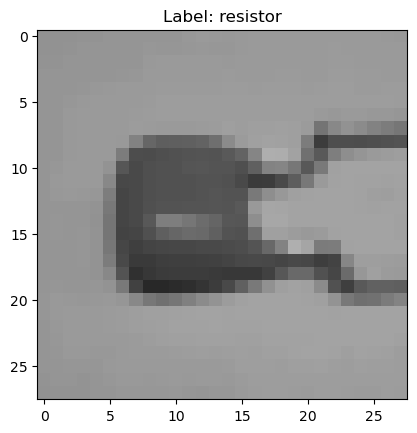

In [22]:
idx = 100

image, lable = train_dataset[idx]

if GRAYSCALE:
    # --- DENORMALIZE ---
    denormalized = image * GRAY_STD + GRAY_MEAN
    # Remove channel dim if needed
    if denormalized.dim() == 3:
        denormalized = denormalized.squeeze(0)  # Now [H, W]
    # Convert to numpy and scale to 0-255
    display_image = (denormalized * 255).numpy().astype('uint8')
    # --- SHOW IMAGE ---
    plt.imshow(display_image, cmap='gray', vmin=0, vmax=255)
else:
    # --- DENORMALIZE RGB ---
    denormalized = image * torch.tensor(STD)[:, None, None] + torch.tensor(MEAN)[:, None, None]
    # Convert to displayable format (HWC for matplotlib)
    display_show = denormalized.permute(1, 2, 0).numpy()  # [H, W, C]
    # Clip values to [0,1] range first
    display_show = np.clip(display_show, 0, 1)
    plt.imshow(display_show)

# --- SHOW IMAGE ---
plt.title(f"Label: {label}")
plt.axis('on')
plt.show()


In [23]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=5):
        super(SimpleCNN, self).__init__()
        
        # Single convolution block
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)  # Output: [32, 28, 28]
        self.bn1 = nn.BatchNorm2d(32)  # Batch norm for conv output
        self.pool = nn.MaxPool2d(2, 2)  # Reduces to [32, 14, 14]
        
        # Dropout
        self.dropout = nn.Dropout(0.4)
        
        # Calculate flattened size
        self.flattened_size = 32 * 14 * 14  # After pooling
        
        # Classifier
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Conv block
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)
        
        # Classifier
        x = x.view(-1, self.flattened_size)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Dropout before final layer
        x = self.fc2(x)
        return x
    def save_model(self):
        
        #############################
        # Saving the model's weitghts
        # Upload 'model' as part of
        # your submission
        # Do not modify this function
        #############################
        
        torch.save(self.state_dict(), 'model')

In [24]:
model = SimpleCNN()

In [25]:
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(in_channels=1, num_classes=5).to(device)  # Your model
summary(model, input_size=(1, 28, 28))  # Grayscale input (1 channel, 28x28)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
         MaxPool2d-3           [-1, 32, 14, 14]               0
           Dropout-4           [-1, 32, 14, 14]               0
            Linear-5                  [-1, 128]         802,944
           Dropout-6                  [-1, 128]               0
            Linear-7                    [-1, 5]             645
Total params: 803,973
Trainable params: 803,973
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.48
Params size (MB): 3.07
Estimated Total Size (MB): 3.55
----------------------------------------------------------------


In [36]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time

# Initialize TensorBoard
writer = SummaryWriter(f'runs/{time.strftime("%Y%m%d-%H%M%S")}')

# Model, optimizer and scheduler
model = SimpleCNN(in_channels=1, num_classes=5)
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

# Data
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)  # Need validation set

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

best_val_loss = float('inf')

for epoch in range(EPOCHS):
    # Training
    model.train()
    train_loss = 0
    train_correct = 0
    
    for batch in train_loader:
        images, labels = batch
        optimizer.zero_grad()
        
        preds = model(images)
        loss = F.cross_entropy(preds, labels)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        train_correct += get_num_correct(preds, labels)
    
    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    
    with torch.no_grad():
        for batch in val_loader:
            images, labels = batch
            preds = model(images)
            loss = F.cross_entropy(preds, labels)
            
            val_loss += loss.item() * images.size(0)
            val_correct += get_num_correct(preds, labels)
    
    # Metrics
    train_loss /= len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # TensorBoard logging
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Accuracy/val', val_acc, epoch)
    writer.add_scalar('Learning Rate', optimizer.param_groups[0]['lr'], epoch)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    
    # Print stats
    print(f'Epoch {epoch+1}/{EPOCHS}: '
          f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | '
          f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | '
          f'LR: {optimizer.param_groups[0]["lr"]:.6f}')

writer.close()

Epoch 1/10: Train Loss: 1.0404 | Train Acc: 0.5733 | Val Loss: 0.8390 | Val Acc: 0.7600 | LR: 0.001000
Epoch 2/10: Train Loss: 0.4229 | Train Acc: 0.8467 | Val Loss: 0.3761 | Val Acc: 0.8800 | LR: 0.001000
Epoch 3/10: Train Loss: 0.2904 | Train Acc: 0.9133 | Val Loss: 0.3155 | Val Acc: 0.8800 | LR: 0.001000
Epoch 4/10: Train Loss: 0.1887 | Train Acc: 0.9267 | Val Loss: 0.3595 | Val Acc: 0.8200 | LR: 0.001000
Epoch 5/10: Train Loss: 0.1223 | Train Acc: 0.9533 | Val Loss: 0.2120 | Val Acc: 0.9200 | LR: 0.001000
Epoch 6/10: Train Loss: 0.1503 | Train Acc: 0.9533 | Val Loss: 0.3268 | Val Acc: 0.8600 | LR: 0.001000
Epoch 7/10: Train Loss: 0.1745 | Train Acc: 0.9333 | Val Loss: 0.2103 | Val Acc: 0.9200 | LR: 0.001000
Epoch 8/10: Train Loss: 0.0965 | Train Acc: 0.9733 | Val Loss: 0.3467 | Val Acc: 0.8800 | LR: 0.001000
Epoch 9/10: Train Loss: 0.1126 | Train Acc: 0.9600 | Val Loss: 0.3266 | Val Acc: 0.8800 | LR: 0.001000
Epoch 10/10: Train Loss: 0.1180 | Train Acc: 0.9333 | Val Loss: 0.2111 | 

In [45]:
## Inference

idx = 0 
val_data = next(iter(val_loader))
val_data

[tensor([[[[0.2051, 0.2097, 0.2097,  ..., 0.2336, 0.2363, 0.2354],
           [0.1981, 0.2143, 0.2143,  ..., 0.2451, 0.2585, 0.2622],
           [0.2097, 0.2143, 0.2235,  ..., 0.2716, 0.2678, 0.2493],
           ...,
           [0.1516, 0.1516, 0.1631,  ..., 0.2757, 0.2803, 0.2803],
           [0.1294, 0.1405, 0.1516,  ..., 0.2470, 0.2692, 0.2692],
           [0.1072, 0.1216, 0.1516,  ..., 0.2327, 0.2406, 0.2360]]],
 
 
         [[[0.0888, 0.0888, 0.0980,  ..., 0.1516, 0.1516, 0.1516],
           [0.0980, 0.1026, 0.1026,  ..., 0.1516, 0.1516, 0.1516],
           [0.1026, 0.1026, 0.1072,  ..., 0.1516, 0.1516, 0.1516],
           ...,
           [0.1461, 0.1424, 0.1470,  ..., 0.1608, 0.1608, 0.1654],
           [0.1428, 0.1516, 0.1516,  ..., 0.1608, 0.1654, 0.1608],
           [0.1415, 0.1470, 0.1516,  ..., 0.1516, 0.1608, 0.1654]]],
 
 
         [[[0.1571, 0.1700, 0.1663,  ..., 0.1930, 0.1768, 0.1865],
           [0.1608, 0.1700, 0.1709,  ..., 0.1911, 0.1795, 0.1818],
           [0.1608